# IBM Stock Market Prediction Using Transformers

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Dataset

In [51]:
# Load the dataset from the CSV file
df = pd.read_csv('DATA/ibm.us.csv')
df.head()


,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,6.4130,6.4130,6.3378,6.3378,467056,0
1,1962-01-03,6.3378,6.3963,6.3378,6.3963,350294,0
2,1962-01-04,6.3963,6.3963,6.3295,6.3295,314365,0
3,1962-01-05,6.3211,6.3211,6.1958,6.2041,440112,0
4,1962-01-08,6.2041,6.2041,6.0373,6.0870,655676,0


# Data Preprocessing

[0.0161103  0.01643002 0.01606494 0.01537958 0.01473958 0.01515003
 0.01519704 0.01556267] 0.015653940894103345
[0.01643002 0.01606494 0.01537958 0.01473958 0.01515003 0.01519704
 0.01556267 0.01565394] 0.015790028851740093


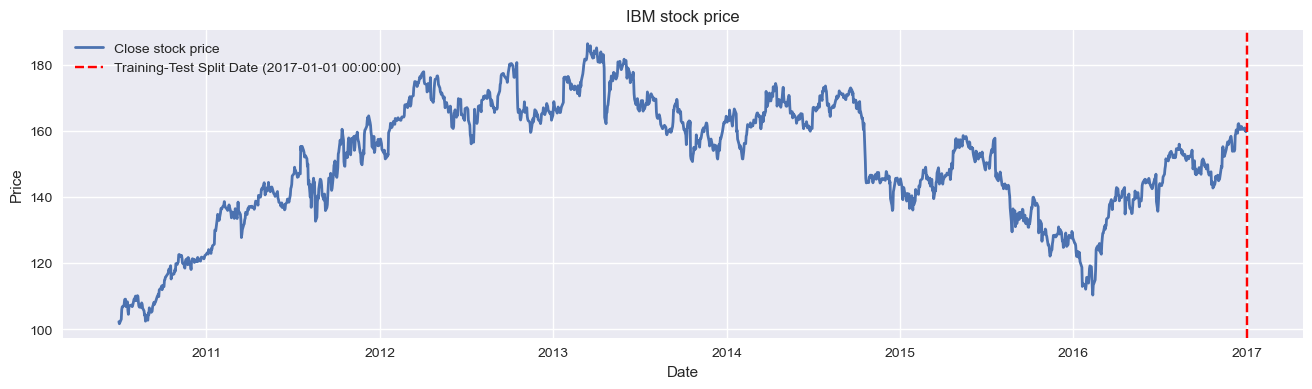

In [52]:
# Rename the columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Remove Rows with null Values
df.dropna(inplace=True)

# Scaling the closing stock values
# As closing stock value is the target variable
sc = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc.fit_transform(df[['Close']])

# Set the number of timesteps
timesteps = 8

# Create data sets where each sample has 8 timesteps and 1 output
x_train = []
y_train = []

for i in range(timesteps, len(train_data_scaled)):
    x_train.append(train_data_scaled[i - timesteps:i, 0])
    y_train.append(train_data_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Print the first two samples
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

# Choose Target Variable and Date Range
target = 'Close'
train_start_date = pd.to_datetime(datetime.date(2010, 7, 1))
train_end_date = pd.to_datetime(datetime.date(2017, 1, 1))
test_start_date = train_end_date

# Filter Data Based on Date Range
train_data = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
test_data = df[df['Date'] >= test_start_date]

# Plot IBM Close Stock Price
plt.figure(figsize=(16, 4))
plt.plot(train_data['Date'], train_data[target], label=f'{target} stock price', linewidth=2)
plt.axvline(x=train_end_date, color='r', linestyle='--', label=f'Training-Test Split Date ({train_end_date})')
plt.legend()
plt.title('IBM stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [53]:
# Check for null values in the entire DataFrame
nan_count = df.isna().sum()

# Print the total count of Null values for each column
print(nan_count)

# Check if there are any Null values in the entire DataFrame
if nan_count.sum() > 0:
    print("There are null values in the DataFrame.")
else:
    print("No null values found in the DataFrame.")


Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64
No null values found in the DataFrame.


# Split Data to train and test

In [54]:
# Convert train_end_date to a datetime object
train_end_date = pd.to_datetime(train_end_date)

# Manually split the data based on date
train_data = df[df['Date'] <= train_end_date]
test_data = df[df['Date'] > train_end_date]


# Data Preprocessing for Time Series Forecasting

In [55]:
# Use MinMaxScaler to scale the training_set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(train_data[['Close']])

# Set the number of timesteps
timesteps = 8

# Create data sets where each sample has 8 timesteps and 1 output
x_train = []
y_train = []

for i in range(timesteps, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape input data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Print the first two samples
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])


[[0.0161103 ]
 [0.01643002]
 [0.01606494]
 [0.01537958]
 [0.01473958]
 [0.01515003]
 [0.01519704]
 [0.01556267]] 0.015653940894103345
[[0.01643002]
 [0.01606494]
 [0.01537958]
 [0.01473958]
 [0.01515003]
 [0.01519704]
 [0.01556267]
 [0.01565394]] 0.015790028851740093


In [56]:
#Checking on null values

input_shape = x_train.shape[1:]
print(input_shape)


nan_indices = np.isnan(x_train) | np.isnan(y_train)
if np.any(nan_indices):
    print("Found null values in the data.")


(8, 1)


# Model Adaptation

In [58]:
# Define the transformer_encoder function
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_blocks, mha_dropout=0, mlp_dropout=0):
    x = inputs

    for _ in range(num_blocks):
        # Multi-Head Self-Attention
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=mha_dropout
        )(x, x)
        x = layers.Dropout(mha_dropout)(attn_output)
        res = x + inputs

        # Feed Forward Neural Network (FFN)
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.Dropout(mlp_dropout)(x)
        x = x + res

    return x

# Define the build_model function
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, num_blocks=num_transformer_blocks, mha_dropout=dropout, mlp_dropout=mlp_dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)  # Linear activation for regression
    return keras.Model(inputs, outputs)

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# Define callbacks and input_shape
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.LearningRateScheduler(lr_scheduler)
]

# changing input_shape to match the shape of input data
input_shape = (8, 1)  

# Build the model
model = build_model(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)


In [60]:
# Compile the model
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)

# Train the model
history = model.fit(
    x_train,
    y_train,  
    validation_split=0.2,
    epochs=10,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/10
554/554 [==============================] - 1456s 3s/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.1065 - val_mean_squared_error: 0.1065 - lr: 1.0000e-06
Epoch 2/10
554/554 [==============================] - 1558s 3s/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 8.5189e-04 - val_mean_squared_error: 8.5189e-04 - lr: 3.4300e-05
Epoch 3/10
554/554 [==============================] - 1569s 3s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.8654e-04 - val_mean_squared_error: 5.8654e-04 - lr: 6.7600e-05
Epoch 4/10
554/554 [==============================] - 1421s 3s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - lr: 1.0090e-04
Epoch 5/10
554/554 [==============================] - 1264s 2s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.4202e-04 - val_mean_squared_error: 4.4202e-04 - lr: 1.3420e-04
Epoch 6/10
554/554 [==============================] - 1273s 2s/step - l

# Evaluate model

7/7 [==============================] - 7s 599ms/step
Mean Squared Error (MSE): 5.98
Mean Absolute Error (MAE): 1.59
Root Mean Squared Error (RMSE): 2.45
Mean Squared Error (MSE): 5.98
Mean Absolute Error (MAE): 1.59
R-squared (R2): 0.95


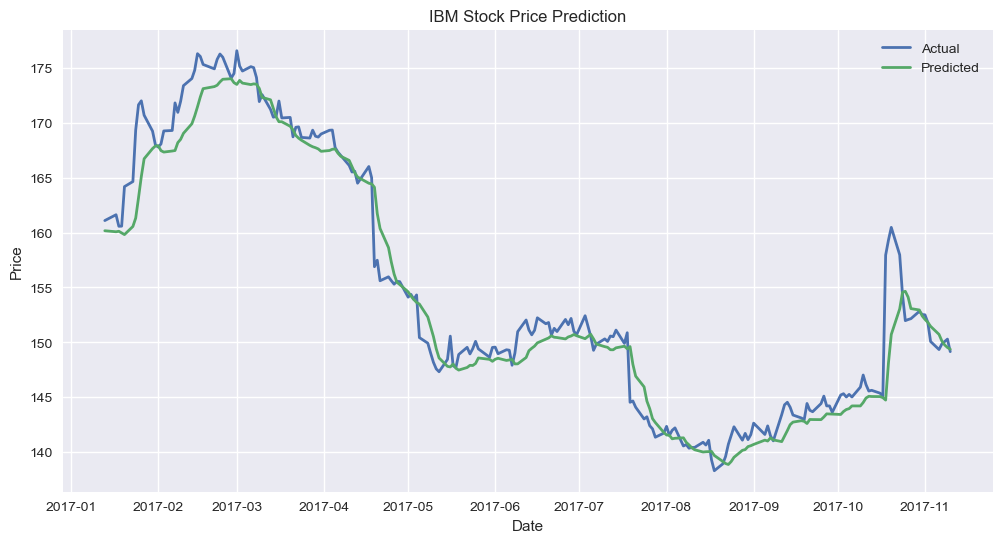

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
import numpy as np
import matplotlib.pyplot as plt



# Evaluate the model on test data
test_data_scaled = sc.transform(test_data[['Close']])  # Scale test data

# Create sequences for test data
x_test = []
y_test = []

for i in range(timesteps, len(test_data_scaled)):
    x_test.append(test_data_scaled[i - timesteps:i, 0])
    y_test.append(test_data_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape input data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Predict on test data
y_pred = model.predict(x_test)

# Inverse transform the predictions and actual values to the original scale
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test.reshape(-1, 1))


# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Plot actual vs. predicted values
test_dates = test_data['Date'].iloc[timesteps:]  # Exclude the first timesteps dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', linewidth=2)
plt.title('IBM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


440/440 [==============================] - 353s 801ms/step


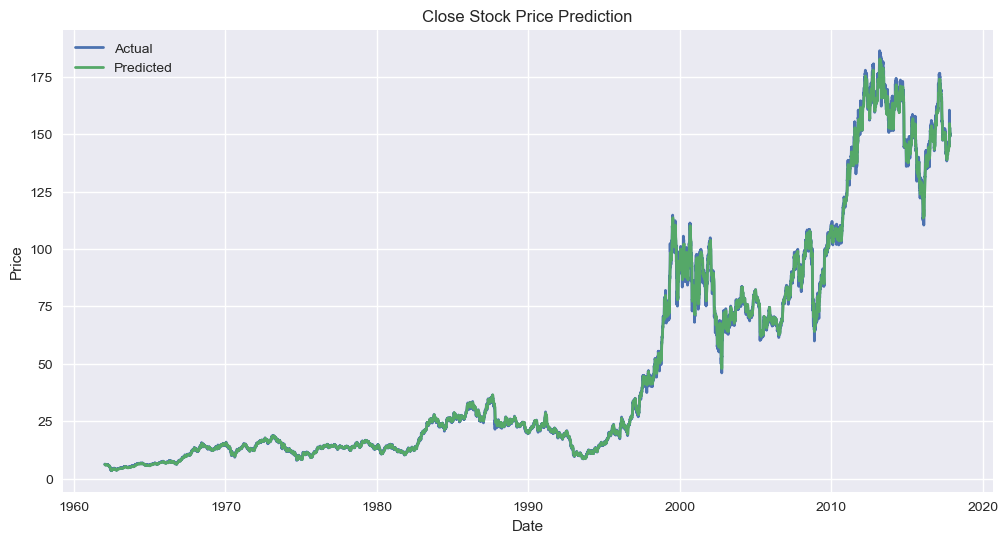

Mean Squared Error (MSE) for Close: 2.16
Mean Absolute Error (MAE) for Close: 0.79
Root Mean Squared Error (RMSE) for Close: 1.47
R-squared (R2) for Close: 1.00


In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('DATA/ibm.us.csv')

# Data Preprocessing
# Rename columns
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Section 1: Data Cleaning - Remove Rows with NaN Values
data.dropna(inplace=True)

# Define a function to make predictions for a given asset
def predict_asset(asset_name):
    # Create a new MinMaxScaler for the asset data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the asset data
    asset_data_scaled = scaler.fit_transform(data[[asset_name]])

    # Create sequences for the asset data
    x_asset = []
    y_asset = []

    for i in range(timesteps, len(asset_data_scaled)):
        x_asset.append(asset_data_scaled[i - timesteps:i, 0])
        y_asset.append(asset_data_scaled[i, 0])

    x_asset, y_asset = np.array(x_asset), np.array(y_asset)

    # Reshape input data
    x_asset = x_asset.reshape((x_asset.shape[0], x_asset.shape[1], 1))

    # Predict on the asset data
    asset_predictions = model.predict(x_asset)

    # Inverse transform the predictions to the original scale
    asset_predictions = scaler.inverse_transform(asset_predictions)

    return asset_predictions

asset_names = ['Close']

# Function to calculate and print evaluation metrics
def evaluate_predictions(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    print(f"Mean Squared Error (MSE) for {asset_name}: {mse:.2f}")
    print(f"Mean Absolute Error (MAE) for {asset_name}: {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE) for {asset_name}: {rmse:.2f}")
    print(f"R-squared (R2) for {asset_name}: {r2:.2f}")

# Plot actual vs. predicted values for each asset
for asset_name in asset_names:
    asset_predictions = predict_asset(asset_name)
    dates = data['Date'][timesteps:]
    actual_data = data[asset_name][timesteps:]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_data, label='Actual', linewidth=2)
    plt.plot(dates, asset_predictions, label='Predicted', linewidth=2)
    plt.title(f'{asset_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate predictions for the asset
    evaluate_predictions(actual_data, asset_predictions)
